In [1]:
%cd notebooks
%cd ..

[Errno 2] No such file or directory: 'notebooks'
/home/ira/code/projects/predictive-learners/notebooks
/home/ira/code/projects/predictive-learners


In [2]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
%matplotlib inline

In [3]:
from pred_learn.models import AE_Predictor
from pred_learn.models.vae_wm import VAE
from pred_learn.data.data_container import ObservationSeriesDataset, ImageSeriesDataset
from pred_learn.utils import stack2wideim, series2wideim

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
from pred_learn.envs import make_env

In [5]:
# ENV_ID = "Catcher-ple-v0"
ENV_ID = "Pong-ple-v0"
# ENV_ID = "TetrisA-v2"
# ENV_ID = "PixelCopter-ple-v0"
# ENV_ID = "PixelCopter-ple-v0"
env = make_env(ENV_ID)

/home/ira/code/envs/flexi/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym_ple.ple_env.PLEEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
action_space_n = env.action_size
series_len = 15
batch_size = 2
workers = 2
dataset_train = ObservationSeriesDataset("clean_records/{}/base-1.torch".format(ENV_ID), action_space_n, series_len)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=workers)

In [12]:
x = next(iter(train_loader))

In [13]:
im = series2wideim(x["s0"])

In [14]:
im.shape

(128, 960, 3)

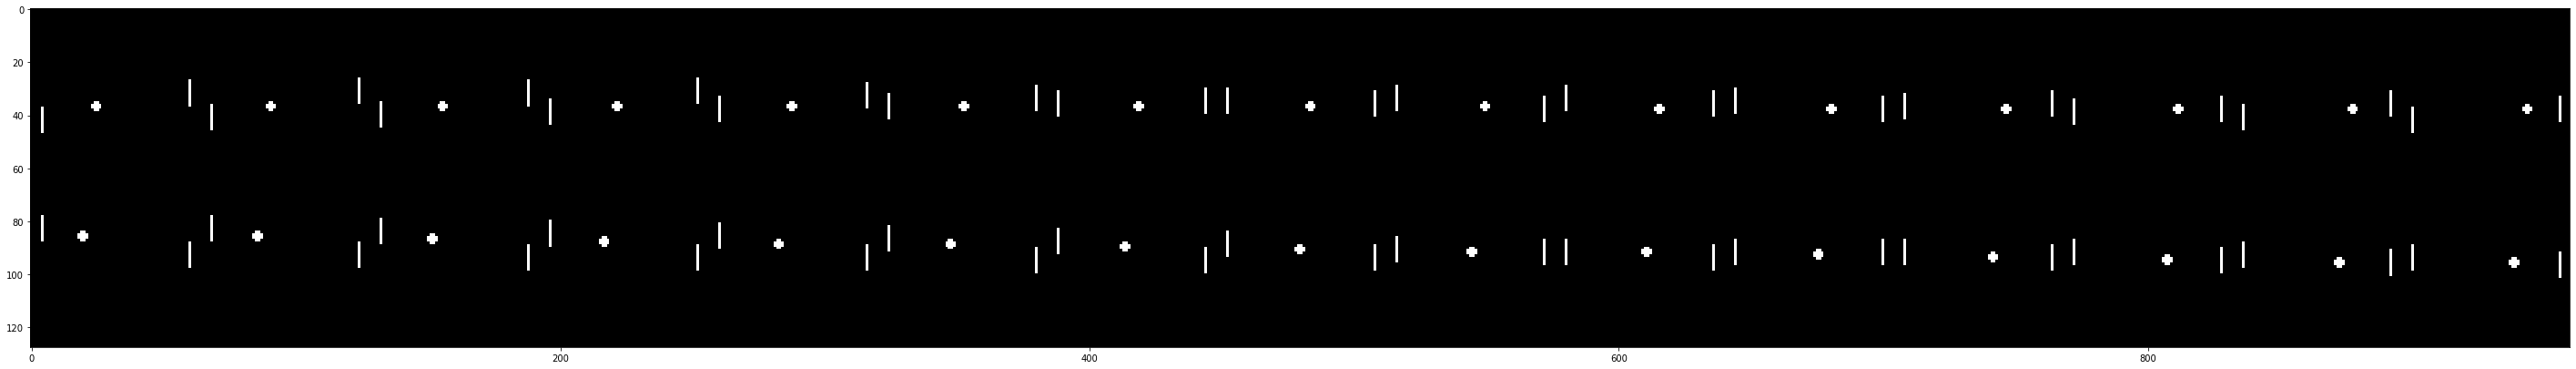

In [15]:
plt.figure(figsize=(50, 20))
plt.imshow(im)

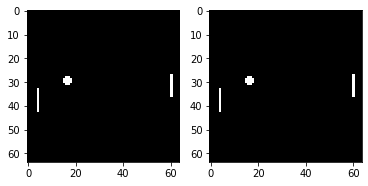

In [12]:
# replay record
with torch.no_grad():
    for i in range(10):
        timestep = dataset_train[i]
        obs = timestep["s0"][0, ...]
#         obs = timestep["s0"]
        
        clear_output(True)
        plt.subplot(121)
        plt.imshow(obs.permute([1,2,0])[..., :3])
    #     obs = resize(obs, (64, 64))
        plt.subplot(122)
#         obs = model(timestep["s0"].unsqueeze(0).cuda())[0].squeeze(0).cpu()
        plt.imshow(obs.permute([1,2,0])[..., :3])

    #     plt.imshow(timestep["s0"])
#         print("reward", timestep['r1'])
#         print("action", timestep['a0'])
        plt.pause(0.01)

In [8]:
model = AE_Predictor(action_space_n).cuda()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss().cuda()
losses = []

In [9]:
# torch.autograd.set_detect_anomaly(True)
for i_epoch in range(20):
    for i_batch, batch in enumerate(train_loader):
        model.zero_grad()
        obs_in = batch["s0"].cuda()
        actions = batch["a0"].cuda()
        obs_target = batch["s1"].cuda()

        obs_recon, obs_preds = model.generate_predictions(obs_in, actions)
        loss = loss_fn(obs_preds, obs_target)
#         loss = loss_fn(obs_recon, obs_in)
        losses.append(loss.item())
        loss.backward()
        optimiser.step()

        if i_batch % 10 == 0:
            clear_output()
            plt.plot(np.log(losses))
            plt.show()


        if i_batch % 101 == 0:
            clear_output()
#             plt.imshow(obs_recon[0, -1].detach().cpu().permute([2,1,0]))
            plt.imshow(obs_recon[0, -1].detach().cpu().permute([2,1,0]))
            plt.pause(1)


KeyboardInterrupt: 

In [10]:
obs_recon.max()

tensor(0.9827, device='cuda:0', grad_fn=<MaxBackward1>)

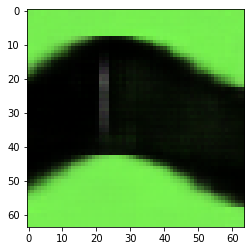

In [11]:
plt.imshow(obs_recon[0, -1].detach().cpu().permute([2,1,0]))

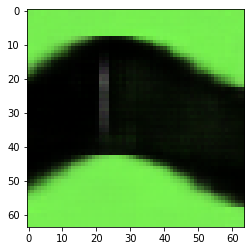

In [18]:
for i in range(15):
    clear_output()
    plt.imshow(obs_recon[0, i].detach().cpu().permute([2,1,0]))
    plt.pause(1)

In [13]:
actions

tensor([[[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [0],
         [1],
         [1],
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         [1],
         [0],
         [1],
         [0],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1]]], device='cuda:0')

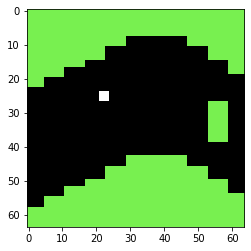

In [14]:
plt.imshow(obs_target[0, 1].detach().cpu().permute([2,1,0]))


In [ ]:
for i_batch, batch in enumerate(train_loader):
    model.zero_grad()
    obs_in = batch["s0"].cuda()
    actions = batch["a0"].cuda()

    o_series = obs_in
    a_series = actions

    belief = None
    o_recons = []
    o_predictions = []
    for t in range(o_series.size(1)):
        o_0 = o_series[:, t, ...]
        a_0 = a_series[:, t, ...]
        # r_t = r_series[:, t, ...]

        o_0_enc = model.image_encoder(o_0).unsqueeze(1)
        # TODO add masking of o_t_enc (skip for initial ts)
        out, belief = model.measurement_updater(o_0_enc, belief)

        o_recon = model.image_decoder(out)
        o_recons.append(o_recon.unsqueeze(1))

        a_0_enc = model.action_encoder(a_0).unsqueeze(1)
        out, belief = model.action_propagator(a_0_enc, belief)
        # TODO add masking of null actions
        out, belief = model.env_propagator(out, belief)
        o_prediction = model.image_decoder(out)
        o_predictions.append(o_prediction.unsqueeze(1))

    o_recons = torch.cat(o_recons, dim=1)
o_predictions = torch.cat(o_predictions, dim=1)

In [ ]:
from pred_learn.models.ae import SimpleAE

In [ ]:
model = SimpleAE().cuda()
optimiser = torch.optim.RMSprop(model.parameters(), lr=0.001)
# optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

# scheduler = ReduceLROnPlateau(optimiser, 'min')
loss_fn = torch.nn.MSELoss().cuda()
losses = []

In [ ]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for i_batch, batch in enumerate(train_loader):
    model.zero_grad()
    obs_in = batch["s0"][:, 0, ...].cuda()
#     actions = batch["a0"].cuda()
#     obs_target = batch["s1"].cuda()
    
    obs_recon = model(obs_in)
    loss = loss_fn(obs_preds, obs_target) # + loss_fn(obs_recon, obs_in)
    losses.append(loss.item())
    loss.backward()
    optimiser.step()
#     scheduler.step(loss.item())
    
    if i_batch % 10 == 0:
        clear_output()
        plt.plot(np.log(losses))
        plt.show()

        
    if i_batch % 101 == 0:
        clear_output()
        plt.imshow(obs_recon[0].detach().cpu().permute([2,1,0]))
        plt.pause(1)


In [ ]:
scheduler.best

In [ ]:
model = VAE(3, 64).cuda()
optimiser = torch.optim.RMSprop(model.parameters(), lr=0.001)
from pred_learn.models.vae_wm import loss_function as loss_fn
losses = []

In [ ]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for i_epoch in range(20):
    for i_batch, batch in enumerate(train_loader):
        model.zero_grad()
        obs_in = batch["s0"][:, 0, ...].cuda()
    #     actions = batch["a0"].cuda()
    #     obs_target = batch["s1"].cuda()

        obs_recon, mu, logsigma = model(obs_in)
        loss = loss_fn(obs_recon, obs_in, mu, logsigma)# + loss_fn(obs_preds, obs_target)
        losses.append(loss.item())
        loss.backward()
        optimiser.step()

        if i_batch % 10 == 0:
            clear_output()
            plt.plot(np.log(losses))
            plt.show()


        if i_batch % 100 == 0:
            clear_output()
            plt.imshow(obs_recon[0].detach().cpu().permute([2,1,0]))
            plt.pause(0.1)


In [ ]:
obs_recon.max()

In [ ]:
plt.hist(obs_recon[1].detach().cpu().permute([2,1,0]).numpy().flatten())

In [ ]:
plt.imshow(obs_recon[0].detach().cpu().permute([2,1,0]))

In [ ]:
logsigma

In [ ]:
plt.imshow(obs_in[0].detach().cpu().permute([2,1,0]))